In [1]:
# Author: Jake VanderPlas (adapted to PyMC3 by Brigitta Sipocz)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

import pymc3 as pm

from astroML.plotting.mcmc import plot_mcmc
from astroML.utils.decorators import pickle_results

In [2]:
# ----------------------------------------------------------------------
# Set up toy dataset
def burst(t, b0, A, alpha, T):
    """Burst model"""
    mask = (t >= T)
    y = b0 + mask * A * np.exp(-alpha * (t - T))
    return y


np.random.seed(0)

N = 100
b0_true = 10
A_true = 5
alpha_true = 0.1
T_true = 50
sigma = 1.0

t = 100 * np.random.random(N)

y_true = burst(t, b0_true, A_true, alpha_true, T_true)
y_obs = np.random.normal(y_true, sigma)



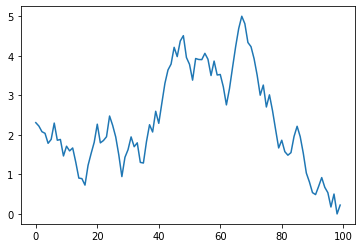

In [3]:
limitesuperior = 5.0
numeropontos = len(y_obs)
 
temporario = np.random.uniform(low=-1, high=1, size=numeropontos)
saida = np.cumsum(temporario)
# normalizamos o sinal para ficar no limite especificado
max_value = max(saida)
min_value = min(saida)
 
for i in range(0, len(saida)):
    saida[i] = ((saida[i] - min_value) / (max_value - min_value)) * limitesuperior

    
x = y_obs + saida    
plt.plot(saida)
plt.show()

In [4]:
# ----------------------------------------------------------------------
# Set up and run the MCMC sampling
# We need to wrap it in a function in order to be able to pickle the result
#@pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(draws=3000, tune=1000):
    with pm.Model():
        b0 = pm.Uniform('b0', 0, 50)
        A = pm.Uniform('A', 0, 50)
        T = pm.Uniform('T', 0, 100)
        log_alpha = pm.Uniform('log_alpha', -10, 10)

        y = pm.Normal('y', mu=burst(t, b0, A, np.exp(log_alpha), T),
                      sd=sigma, observed=x)

        traces = pm.sample(draws=draws, tune=tune)

        return traces


traces = compute_MCMC_results()
mean_vals = pm.summary(traces)['mean']
mean_vals['alpha'] = np.exp(mean_vals.pop('log_alpha'))

labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']

limits = [(9.2, 11.2), (2, 12), (45, 55), (0.0, 0.25)]
true = [b0_true, A_true, T_true, alpha_true]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_alpha, T, A, b0]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 16000/16000 [07:33<00:00,  8.18draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 779 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.19425772084741894, but should be close to 0.8. Try to increase the number of tuning steps.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3334552226007845, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. 

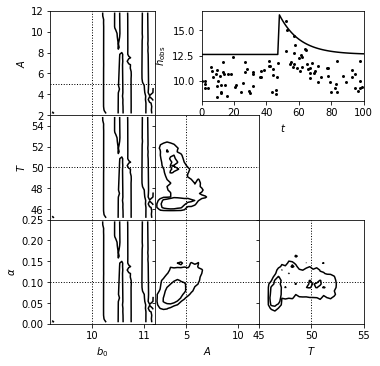

In [5]:
# ------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([traces[i] for i in ['b0', 'A', 'T']] + [np.exp(traces['log_alpha'])],
          labels=labels, limits=limits,
          true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = burst(t_fit, **mean_vals)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.plot(t_fit, y_fit, '-k')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()